<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week8-UTS/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import math
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Set seeds untuk reproduksibilitas
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
# Memuat dataset
df = pd.read_csv('/content/drive/MyDrive/DeepLearning/RegresiUTSTelkom.csv')


In [17]:
# Melihat informasi dasar dataset
print("Informasi Dataset:")
print(f"Jumlah baris dan kolom: {df.shape}")
print("\nLima baris pertama:")
print(df.head())
print("\nDeskripsi statistik:")
print(df.describe())
print("\nInfo tipe data:")
print(df.info())

Informasi Dataset:
Jumlah baris dan kolom: (515344, 91)

Lima baris pertama:
   2001  49.94357  21.47114   73.0775   8.74861  -17.40628  -13.09905  \
0  2001  48.73215  18.42930  70.32679  12.94636  -10.32437  -24.83777   
1  2001  50.95714  31.85602  55.81851  13.41693   -6.57898  -18.54940   
2  2001  48.24750  -1.89837  36.29772   2.58776    0.97170  -26.21683   
3  2001  50.97020  42.20998  67.09964   8.46791  -15.85279  -16.81409   
4  2001  50.54767   0.31568  92.35066  22.38696  -25.51870  -19.04928   

   -25.01202  -12.23257   7.83089  ...   13.0162  -54.40548  58.99367  \
0    8.76630   -0.92019  18.76548  ...   5.66812  -19.68073  33.04964   
1   -3.27872   -2.35035  16.07017  ...   3.03800   26.05866 -50.92779   
2    5.05097  -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705   
3  -12.48207   -9.37636  12.63699  ...   9.92661  -55.95724  64.92712   
4   20.67345   -5.19943   3.63566  ...   6.59753  -50.69577  26.02574   

   15.37344   1.11144  -23.08793   68.40795  

In [18]:
# Cek missing values
print("\nJumlah missing values per kolom:")
print(df.isnull().sum())


Jumlah missing values per kolom:
2001         0
49.94357     0
21.47114     0
73.0775      0
8.74861      0
            ..
-23.08793    0
68.40795     0
-1.82223     0
-27.46348    0
2.26327      0
Length: 91, dtype: int64


### Feature Engineering dan Preprocessing
 Kita asumsikan kolom terakhir adalah target (bisa disesuaikan)
 1. Model regresi untuk memprediksi kolom terakhir dalam nilai numerik aslinya
 2. Model klasifikasi dengan mengubah target menjadi kategori (diatas/dibawah median)


In [19]:
# Pisahkan fitur dan target
X = df.iloc[:, :-1]  # Semua kolom kecuali kolom terakhir
y = df.iloc[:, -1]   # Kolom terakhir

In [20]:
# Membuat target klasifikasi (untuk model klasifikasi)
# Kita akan membuat target biner berdasarkan median
y_class = (y > y.median()).astype(int)

print("\nDistribusi kelas target klasifikasi:")
print(y_class.value_counts())


Distribusi kelas target klasifikasi:
2.26327
1    257672
0    257672
Name: count, dtype: int64


### Preprocessing Pipeline
pipeline preprocessing:
1. Menangani missing values dengan impute
2. Melakukan standardisasi pada semua fitur numerik


In [21]:
# Membagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)


In [22]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns


In [23]:
# Jika ada kolom kategorikal, kita bisa menambahkan one-hot encoding
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features)
    ])

In [24]:
# Jika ada fitur kategorikal, tambahkan ke preprocessor
if len(categorical_features) > 0:
    preprocessor.transformers.append(
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    )

In [25]:
# Fit preprocessor pada data training
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['2001', '49.94357', '21.47114', '73.0775', '8.74861', '-17.40628',
       '-13.09905', '-25.01202', '-12.23257', '7.83089', '-2.46783', '3.32136',
       '-2.31521', '10.20556', '611.10913', '951.0896', '698.11428',
       '408.98485', '383.70912', '326...
       '-44.5911', '-8.30657', '7.93706', '-10.7366', '-95.44766', '-82.03307',
       '-35.59194', '4.69525', '70.95626', '28.09139', '6.02015', '-37.13767',
       '-41.1245', '-8.40816', '7.19877', '-8.60176', '-5.90857', '-12.32437',
       '14.68734', '-54.32125', '40.14786', '13.0162', '-54.40548', '58.99367',
       '15.37344', '1.11144', '-23.08793', '68.40795', '-1.82223',
       '-27.46348'],
      dtype='object'))])

In [26]:
# Transform data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_train_class_processed = preprocessor.transform(X_train_class)
X_test_class_processed = preprocessor.transform(X_test_class)


In [27]:
# Memeriksa hasil transformasi
print("\nBentuk data setelah preprocessing:")
print(f"X_train_processed: {X_train_processed.shape}")
print(f"X_test_processed: {X_test_processed.shape}")



Bentuk data setelah preprocessing:
X_train_processed: (412275, 90)
X_test_processed: (103069, 90)


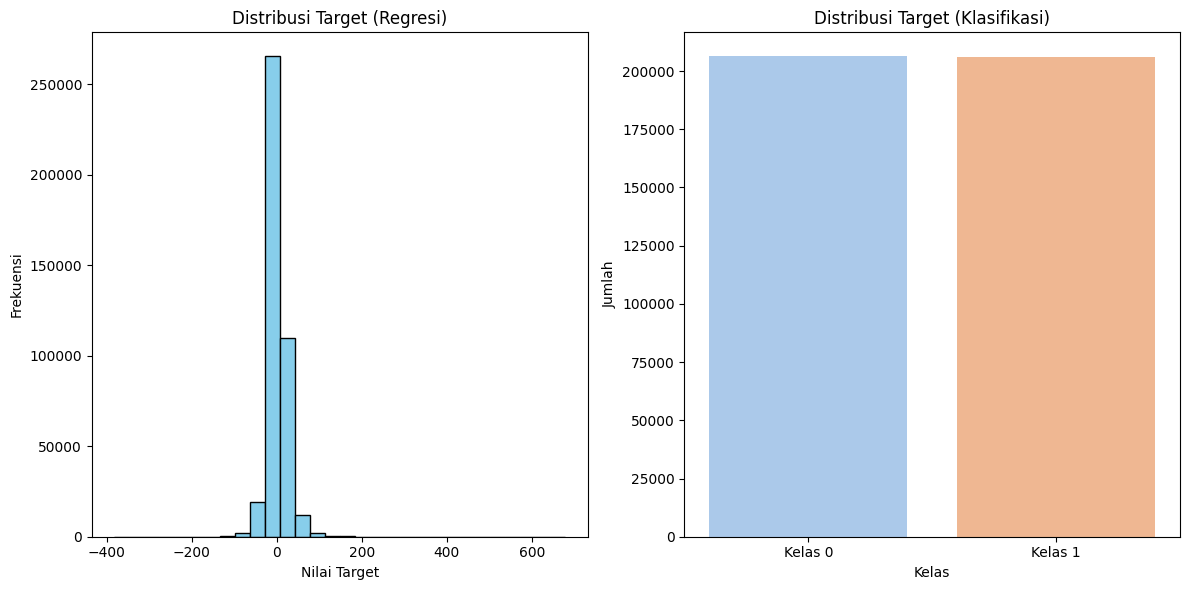

In [28]:
# Visualisasi distribusi data setelah preprocessing
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Distribusi Target (Regresi)")
plt.hist(y_train, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Nilai Target")
plt.ylabel("Frekuensi")

plt.subplot(1, 2, 2)
plt.title("Distribusi Target (Klasifikasi)")
sns.countplot(x=y_train_class, palette='pastel')
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.xticks([0, 1], ['Kelas 0', 'Kelas 1'])
plt.tight_layout()
plt.show()


Tidak ada fitur kategorikal untuk One-Hot Encoding


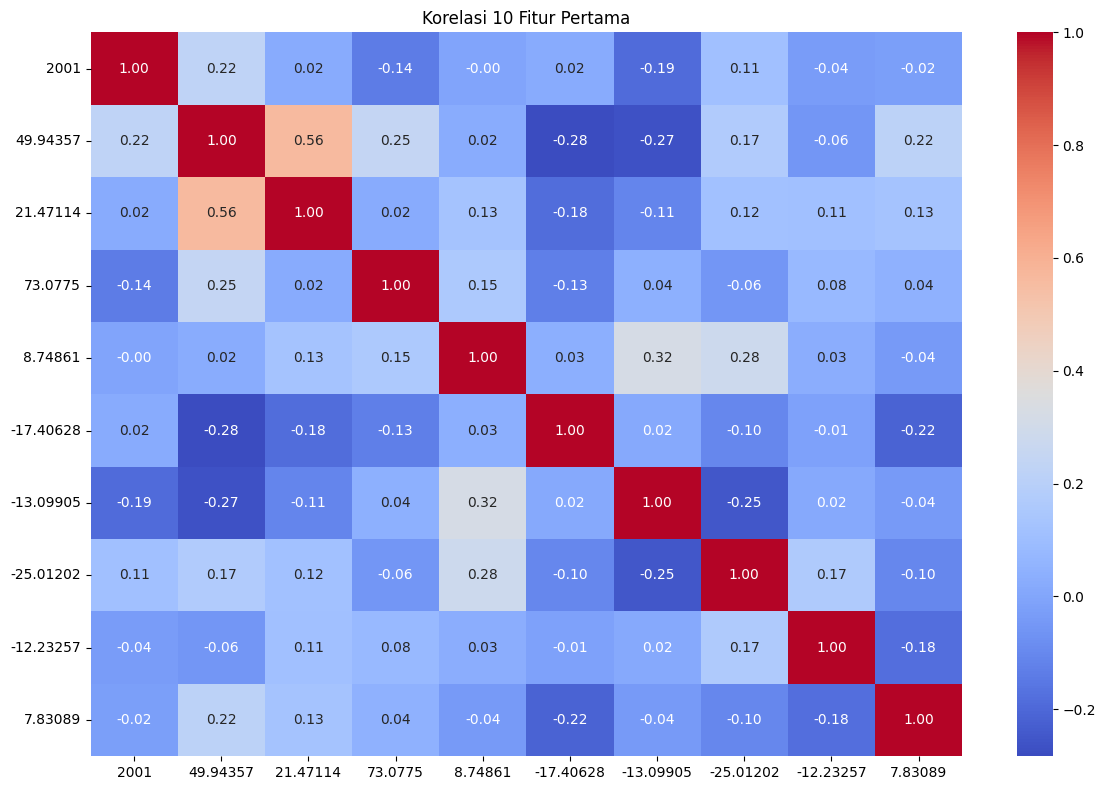

In [29]:
# Visualisasi hasil One-Hot Encoding (jika ada fitur kategorikal)
if len(categorical_features) > 0:
    print("\nVisualisasi One-Hot Encoding:")
    # Mengambil sampel data untuk visualisasi
    sample_data = X_train.sample(5)

    # One-hot encode sampel
    ohe = OneHotEncoder(sparse=False)
    sample_encoded = ohe.fit_transform(sample_data[categorical_features])

    # Membuat DataFrame untuk visualisasi
    encoded_df = pd.DataFrame(
        sample_encoded,
        columns=ohe.get_feature_names_out(categorical_features)
    )

    # Visualisasi
    plt.figure(figsize=(12, 6))
    sns.heatmap(encoded_df, cmap='viridis', cbar=True, annot=True)
    plt.title('Visualisasi One-Hot Encoding')
    plt.tight_layout()
    plt.show()
else:
    print("\nTidak ada fitur kategorikal untuk One-Hot Encoding")
    # Sebagai gantinya, tampilkan visualisasi korelasi fitur
    plt.figure(figsize=(12, 8))
    corr = X_train.corr().iloc[:10, :10]  # Mengambil 10x10 pertama untuk kemudahan visualisasi
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Korelasi 10 Fitur Pertama')
    plt.tight_layout()
    plt.show()

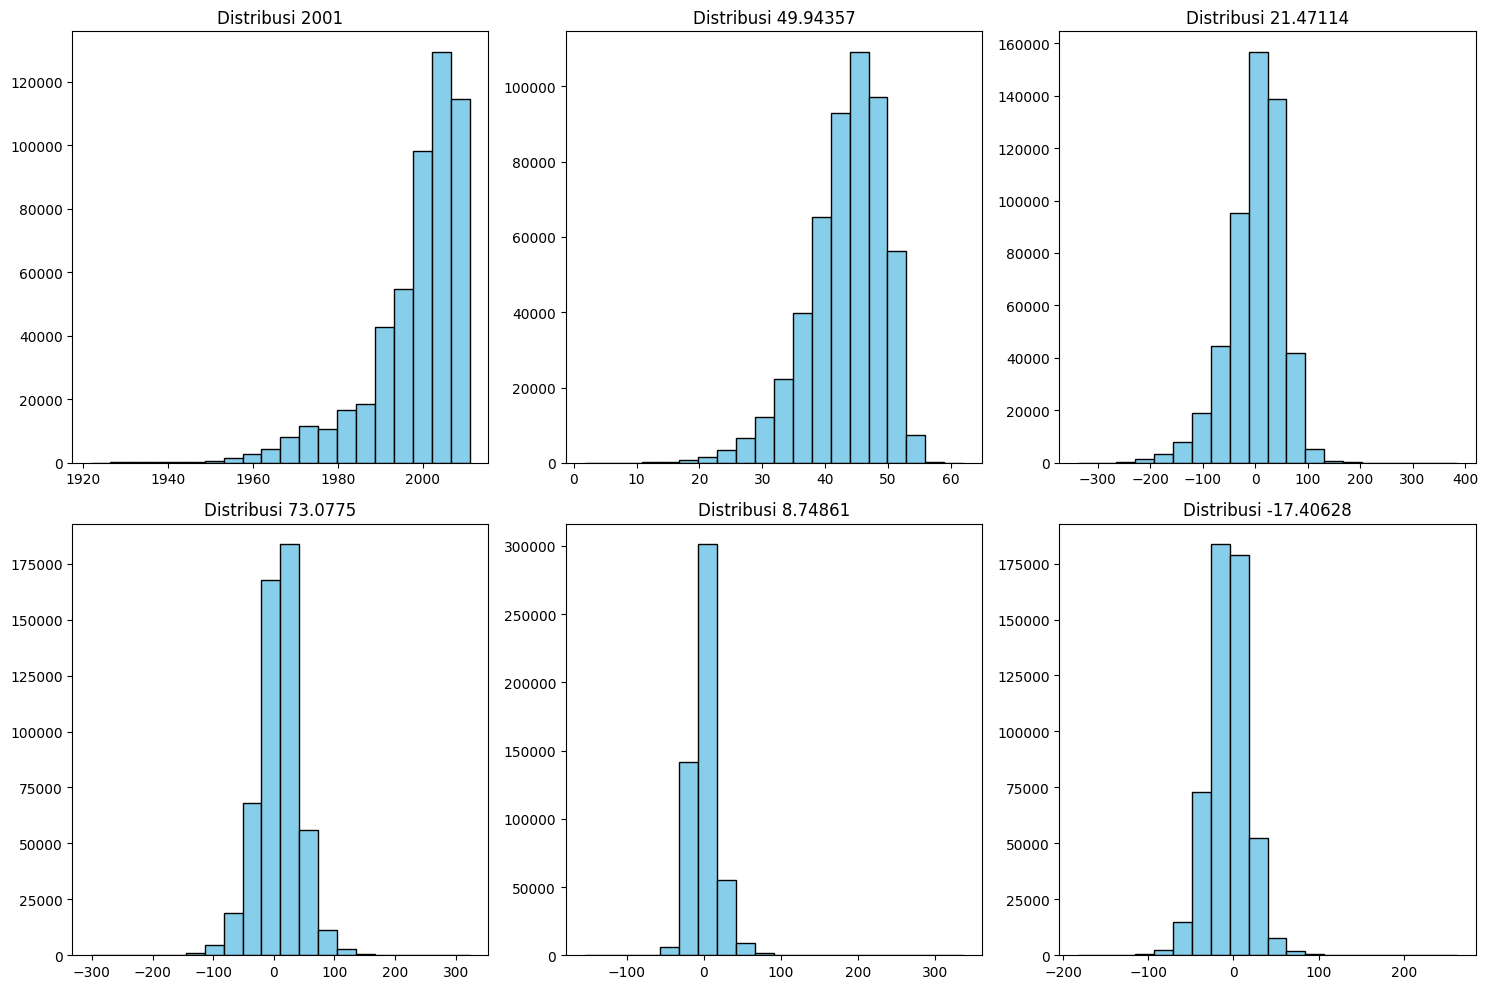

In [30]:
# Visualisasi distribusi beberapa fitur
plt.figure(figsize=(15, 10))
for i, col in enumerate(X.columns[:6]):  # Hanya menampilkan 6 fitur pertama
    plt.subplot(2, 3, i+1)
    plt.hist(X[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

In [31]:
# Model Deep Learning untuk REGRESI
print("\n--- MEMBUAT MODEL REGRESI ---")


--- MEMBUAT MODEL REGRESI ---


In [32]:
def create_regression_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer tanpa aktivasi untuk regresi
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse'
    )
    return model

In [33]:
# Membuat dan melatih model regresi
reg_model = create_regression_model(X_train_processed.shape[1])
print(reg_model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,017 (86.00 KB)

 Trainable params: 22,017 (86.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [34]:
# Melatih model dengan callback
history_reg = reg_model.fit(
    X_train_processed, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ],
    verbose=1
)

Epoch 1/20
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 230.6888 - val_loss: 113.5573
Epoch 2/20
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 134.1642 - val_loss: 103.8607
Epoch 3/20
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 121.3035 - val_loss: 99.9723
Epoch 4/20
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 115.2812 - val_loss: 101.9225
Epoch 5/20
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 111.0934 - val_loss: 106.0065
Epoch 6/20
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 108.9844 - val_loss: 101.4124
Epoch 7/20
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 106.2245 - val_loss: 104.0797
Epoch 8/20
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 103.7505 - val_loss: 105.0044


In [36]:
# Evaluasi model regresi
y_pred_reg = reg_model.predict(X_test_processed)

# Menghitung metrik evaluasi
mse = mean_squared_error(y_test, y_pred_reg)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred_reg)

print("\nHasil Evaluasi Model Regresi:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

3221/3221 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

Hasil Evaluasi Model Regresi:
MSE: 100.5567
RMSE: 10.0278
R²: 0.7935


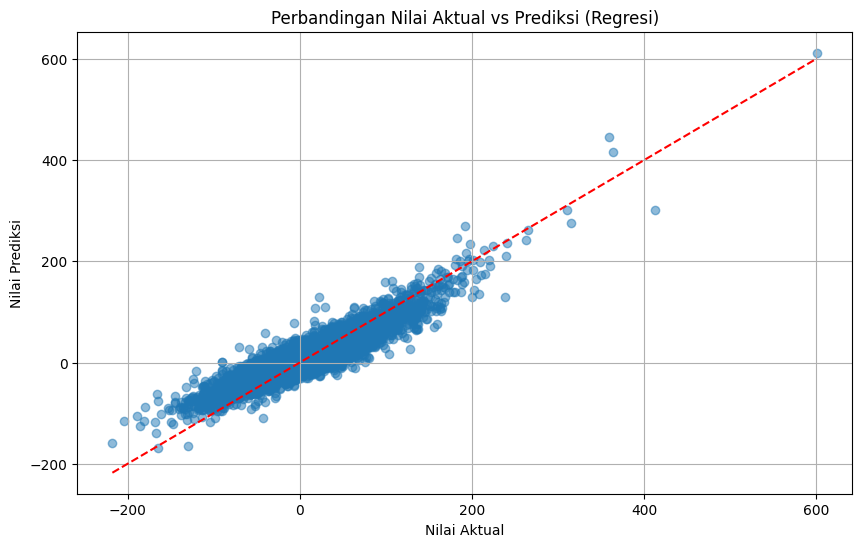

In [37]:
# Visualisasi hasil prediksi vs aktual untuk regresi
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_reg, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Perbandingan Nilai Aktual vs Prediksi (Regresi)")
plt.grid(True)
plt.show()

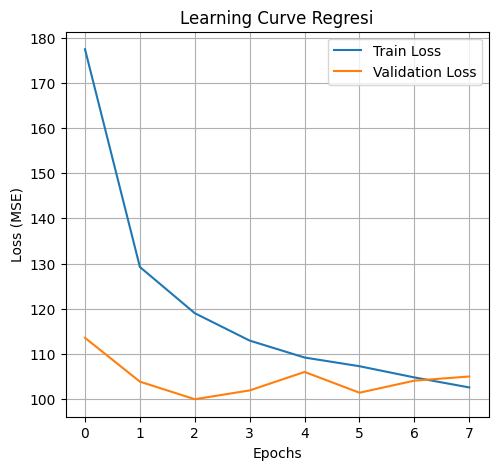

In [38]:
# Visualisasi learning curve untuk regresi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'], label='Train Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve Regresi')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

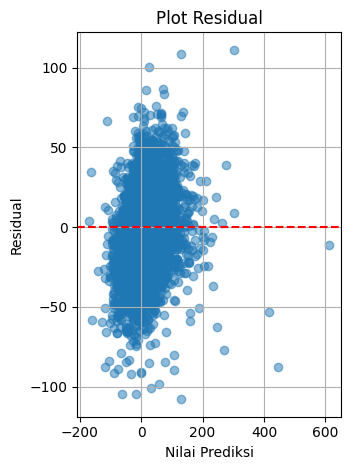

In [39]:
# Visualisasi residual untuk regresi
plt.subplot(1, 2, 2)
residuals = y_test - y_pred_reg.flatten()
plt.scatter(y_pred_reg, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Plot Residual')
plt.xlabel('Nilai Prediksi')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# Model Deep Learning untuk KLASIFIKASI
print("\n--- MEMBUAT MODEL KLASIFIKASI ---")



--- MEMBUAT MODEL KLASIFIKASI ---


In [41]:
def create_classification_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Output layer dengan aktivasi sigmoid untuk klasifikasi biner
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [42]:
# Membuat dan melatih model klasifikasi
class_model = create_classification_model(X_train_class_processed.shape[1])
print(class_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,017 (86.00 KB)

 Trainable params: 22,017 (86.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [46]:
# Melatih model dengan callback
history_class = class_model.fit(
    X_train_class_processed, y_train_class,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ],
    verbose=1
)

Epoch 1/5
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.8242 - loss: 0.3767 - val_accuracy: 0.8345 - val_loss: 0.3597
Epoch 2/5
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.8252 - loss: 0.3753 - val_accuracy: 0.8365 - val_loss: 0.3565
Epoch 3/5
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.8258 - loss: 0.3726 - val_accuracy: 0.8371 - val_loss: 0.3555
Epoch 4/5
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8272 - loss: 0.3688 - val_accuracy: 0.8365 - val_loss: 0.3551
Epoch 5/5
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.8289 - loss: 0.3671 - val_accuracy: 0.8364 - val_loss: 0.3542


In [47]:
# Evaluasi model klasifikasi
y_pred_class_prob = class_model.predict(X_test_class_processed)
y_pred_class = (y_pred_class_prob > 0.5).astype(int)


3221/3221 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [48]:
# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)
auc_roc = roc_auc_score(y_test_class, y_pred_class_prob)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

print("\nHasil Evaluasi Model Klasifikasi:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class))



Hasil Evaluasi Model Klasifikasi:
Accuracy: 0.8332
Precision: 0.8382
Recall: 0.8273
F1-Score: 0.8327
AUC-ROC: 0.9193

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83     51365
           1       0.84      0.83      0.83     51704

    accuracy                           0.83    103069
   macro avg       0.83      0.83      0.83    103069
weighted avg       0.83      0.83      0.83    103069



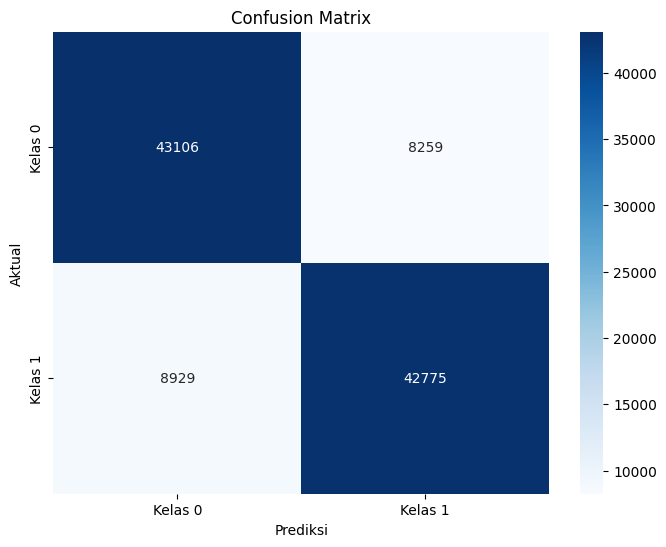

In [49]:
# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Kelas 0', 'Kelas 1'],
            yticklabels=['Kelas 0', 'Kelas 1'])
plt.title('Confusion Matrix')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

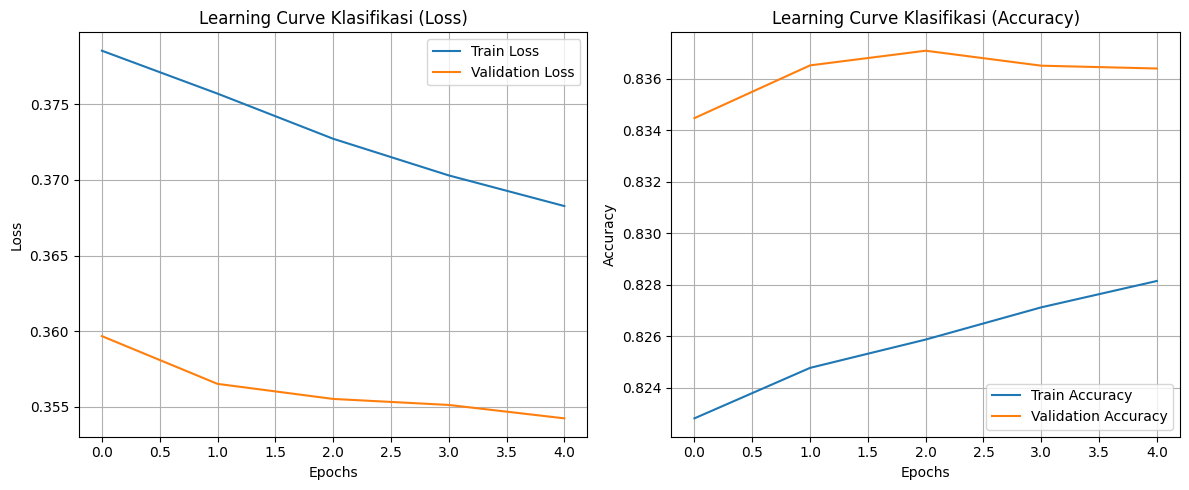

In [50]:
# Visualisasi learning curve untuk klasifikasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_class.history['loss'], label='Train Loss')
plt.plot(history_class.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve Klasifikasi (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_class.history['accuracy'], label='Train Accuracy')
plt.plot(history_class.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve Klasifikasi (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
# Menentukan metrik terbaik untuk regresi
print("\n--- METRIK TERBAIK UNTUK REGRESI ---")
print("Rangkuman metrik evaluasi regresi:")
metrics_reg = {
    'MSE': mse,
    'RMSE': rmse,
    'R²': r2
}
best_metric_reg = max(metrics_reg.items(), key=lambda x: x[1] if x[0] == 'R²' else -x[1])
print(f"MSE: {mse:.4f} (semakin kecil semakin baik)")
print(f"RMSE: {rmse:.4f} (semakin kecil semakin baik)")
print(f"R²: {r2:.4f} (semakin mendekati 1 semakin baik)")

if best_metric_reg[0] == 'R²':
    print(f"\nMetrik terbaik untuk model regresi adalah R² dengan nilai {best_metric_reg[1]:.4f}")
    print("R² mengukur proporsi variasi dalam variabel dependen yang dapat dijelaskan oleh model.")
    print("Nilai R² yang mendekati 1 menunjukkan model yang sangat baik.")
else:
    print(f"\nMetrik terbaik untuk model regresi adalah {best_metric_reg[0]} dengan nilai {best_metric_reg[1]:.4f}")
    print("Nilai error yang rendah (MSE/RMSE) menunjukkan model yang baik.")



--- METRIK TERBAIK UNTUK REGRESI ---
Rangkuman metrik evaluasi regresi:
MSE: 100.5567 (semakin kecil semakin baik)
RMSE: 10.0278 (semakin kecil semakin baik)
R²: 0.7935 (semakin mendekati 1 semakin baik)

Metrik terbaik untuk model regresi adalah R² dengan nilai 0.7935
R² mengukur proporsi variasi dalam variabel dependen yang dapat dijelaskan oleh model.
Nilai R² yang mendekati 1 menunjukkan model yang sangat baik.


In [52]:
# Menentukan metrik terbaik untuk klasifikasi
print("\n--- METRIK TERBAIK UNTUK KLASIFIKASI ---")
print("Rangkuman metrik evaluasi klasifikasi:")
metrics_class = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC-ROC': auc_roc
}

for name, value in metrics_class.items():
    print(f"{name}: {value:.4f}")



--- METRIK TERBAIK UNTUK KLASIFIKASI ---
Rangkuman metrik evaluasi klasifikasi:
Accuracy: 0.8332
Precision: 0.8382
Recall: 0.8273
F1-Score: 0.8327
AUC-ROC: 0.9193


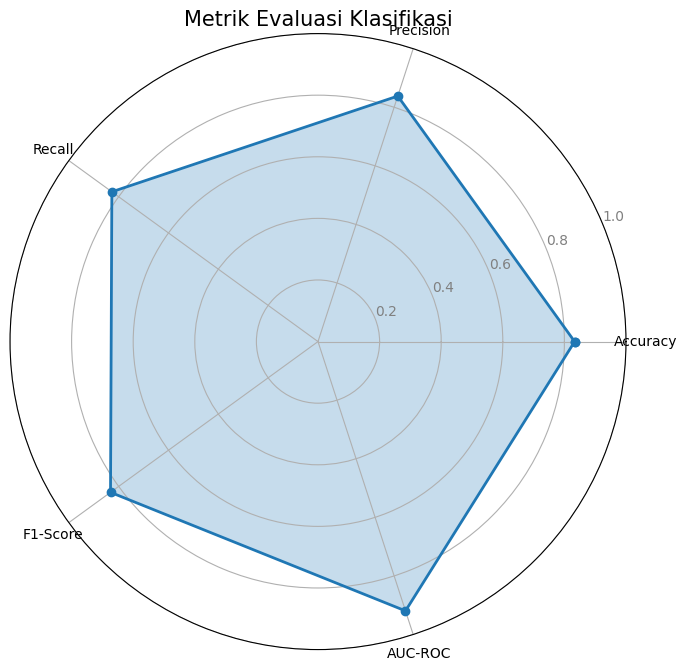


Metrik terbaik untuk model klasifikasi adalah AUC-ROC dengan nilai 0.9193


In [53]:
# Visualisasi metrik klasifikasi dalam bentuk radar chart
plt.figure(figsize=(8, 8))
categories = list(metrics_class.keys())
values = list(metrics_class.values())
values += values[:1]  # Duplicate first value to close the circle
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Duplicate first angle to close the circle
categories += categories[:1]  # Duplicate first category to close the circle

plt.polar(angles, values, 'o-', linewidth=2)
plt.fill(angles, values, alpha=0.25)
plt.xticks(angles[:-1], categories[:-1])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ['0.2', '0.4', '0.6', '0.8', '1.0'], color='gray')
plt.ylim(0, 1)
plt.title('Metrik Evaluasi Klasifikasi', size=15)
plt.show()

best_metric_class = max(metrics_class.items(), key=lambda x: x[1])
print(f"\nMetrik terbaik untuk model klasifikasi adalah {best_metric_class[0]} dengan nilai {best_metric_class[1]:.4f}")


In [54]:
print("\nPenjelasan metrik terbaik:")
if best_metric_class[0] == 'Accuracy':
    print("Accuracy mengukur proporsi total prediksi yang benar. Baik untuk dataset yang seimbang.")
elif best_metric_class[0] == 'Precision':
    print("Precision mengukur proporsi prediksi positif yang benar. Baik ketika false positive harus diminimalkan.")
elif best_metric_class[0] == 'Recall':
    print("Recall mengukur proporsi kasus positif aktual yang teridentifikasi dengan benar. Baik ketika false negative harus diminimalkan.")
elif best_metric_class[0] == 'F1-Score':
    print("F1-Score adalah rata-rata harmonik dari precision dan recall. Baik untuk dataset yang tidak seimbang.")
elif best_metric_class[0] == 'AUC-ROC':
    print("AUC-ROC mengukur kemampuan model untuk membedakan antara kelas. Nilai 1 menunjukkan model sempurna.")

print("\nKesimpulan:")
print(f"Untuk model regresi, {best_metric_reg[0]} adalah metrik terbaik dengan nilai {best_metric_reg[1]:.4f}.")
print(f"Untuk model klasifikasi, {best_metric_class[0]} adalah metrik terbaik dengan nilai {best_metric_class[1]:.4f}.")


Penjelasan metrik terbaik:
AUC-ROC mengukur kemampuan model untuk membedakan antara kelas. Nilai 1 menunjukkan model sempurna.

Kesimpulan:
Untuk model regresi, R² adalah metrik terbaik dengan nilai 0.7935.
Untuk model klasifikasi, AUC-ROC adalah metrik terbaik dengan nilai 0.9193.


# Analisis

## 1. Modifikasi Arsitektur MLP untuk Mengatasi Underfitting

Jika model MLP (256-128-64) mengalami underfitting, modifikasi berikut dapat dilakukan:

### Modifikasi yang Diusulkan:
- **Meningkatkan kompleksitas model** (512-256-128 atau menambah layer)
- **Menurunkan regularisasi** (mengurangi dropout atau L2)
- **Menggunakan aktivasi non-linear yang lebih kompleks** (Leaky ReLU)
- **Memodifikasi optimizer** (meningkatkan learning rate)

### Analisis Bias-Variance:
- Underfitting menunjukkan **bias tinggi** dan **variance rendah**
- Meningkatkan kompleksitas menurunkan bias, tetapi berisiko meningkatkan variance
- Mengurangi regularisasi membantu model menangkap lebih banyak pola
- Keseimbangan antara kapasitas model dan regularisasi adalah kunci

## 2. Alternatif Loss Function

### Huber Loss
- **Kelebihan**: Gabungan MSE dan MAE, robust terhadap outlier
- **Kekurangan**: Perlu tuning hyperparameter delta
- **Unggul pada**: Dataset dengan beberapa outlier signifikan

### Mean Absolute Error (MAE)
- **Kelebihan**: Sangat robust terhadap outlier
- **Kekurangan**: Gradien konstan, konvergensi lambat
- **Unggul pada**: Dataset dengan noise besar atau outlier ekstrem

### Log-Cosh Loss
- **Kelebihan**: Gabungan sifat MSE dan MAE, optimasi stabil
- **Kekurangan**: Komputasi lebih rumit
- **Unggul pada**: Dataset dengan kombinasi nilai normal dan beberapa outlier

## 3. Pengaruh Perbedaan Skala Fitur (0-1 vs 100-1000)

### Mekanisme yang Terdampak:
- **Gradien**: Fitur berskala besar menghasilkan gradien besar, menyebabkan ketidakstabilan
- **Weight Updates**: Bobot untuk fitur skala besar berubah cepat, fitur skala kecil berubah lambat
- **Feature Dominance**: Fitur berskala besar mendominasi perhitungan di hidden layer

### Dampak:
- Konvergensi lambat atau gagal
- Model bias terhadap fitur berskala besar
- Stabilitas numerik berkurang

Normalisasi/standardisasi fitur sangat penting untuk mengatasi masalah ini.

## 4. Mengukur Kontribusi Fitur

### 1. Permutation Feature Importance
- **Metodologi**: Acak nilai fitur, ukur penurunan performa
- **Keterbatasan**: Tidak menangkap interaksi kompleks, komputasi mahal

### 2. SHAP Values
- **Metodologi**: Menghitung kontribusi marginal untuk setiap kombinasi fitur
- **Keterbatasan**: Komputasi intensif, interpretasi kompleks

### 3. Integrated Gradients
- **Metodologi**: Mengintegrasikan gradien dari baseline ke input aktual
- **Keterbatasan**: Memerlukan model diferensiabel, sensitif terhadap baseline

### 4. Analisis Bobot Model
- **Metodologi**: Analisis magnitude bobot dari input ke layer pertama
- **Keterbatasan**: Sederhana, tidak memperhitungikan interaksi antar fitur

## 5. Eksperimen untuk Learning Rate dan Batch Size

### Metodologi:
1. **Learning Rate Range Test**: Identifikasi rentang learning rate potensial
2. **Grid Search**: Uji kombinasi LR dan batch size dengan validasi silang
3. **Learning Rate Schedulers**: Uji berbagai scheduler untuk kombinasi terbaik

### Tradeoffs:
- **Batch Size Kecil**: Efek regularisasi, update lebih sering, tetapi kurang efisien
- **Batch Size Besar**: Estimasi gradien akurat, efisien komputasi, tetapi memori besar
- **LR Kecil**: Stabil tetapi lambat
- **LR Besar**: Potensial cepat tetapi berisiko divergen

Relasi empiris: $\eta_{\text{new}} = \eta_{\text{base}} \times \sqrt{\frac{\text{BS}_{\text{new}}}{\text{BS}_{\text{base}}}}$

Eksperimen mencari keseimbangan antara kecepatan konvergensi, stabilitas, performa, dan efisiensi komputasi.